### Importing Libraries

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, DepthwiseConv2D, GlobalAveragePooling2D, Reshape, Dense, Multiply, Add

2024-04-22 03:23:08.331134: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-22 03:23:08.385408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 03:23:09.328663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/saad-bscs/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a 

### Constants

In [2]:
batch_size = 32
num_classes = 124
tf.random.set_seed(42)
img_height, img_width = 128, 128
data_dir = os.path.join(os.getcwd(), "../5-Gait-Energy-Images")

### Training Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rescale=1.0 / 255,
    rotation_range=20,
    fill_mode="nearest",
    horizontal_flip=True,
    zoom_range=[0.8, 1.2],
    width_shift_range=0.2,
    validation_split=0.15,
    height_shift_range=0.2,
    channel_shift_range=10,
    brightness_range=[0.8, 1.2],
)

### Testing Data Augmentation

In [4]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.15)

### Load and split data into training and testing sets

In [5]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=True,
    subset="training",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

test_generator = test_datagen.flow_from_directory(
    data_dir,
    seed=42,
    shuffle=False,
    subset="validation",
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    target_size=(img_height, img_width),
)

Found 11587 images belonging to 124 classes.
Found 1974 images belonging to 124 classes.


### EfficientNetB0 Model

In [6]:
def efficientnet_b0_block(inputs, filters, kernel_size, strides=(1, 1), expansion=1):
    channel_axis = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
    in_channels = tf.keras.backend.int_shape(inputs)[channel_axis]

    x = Conv2D(expansion * in_channels, kernel_size=1, padding='same')(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('swish')(x)

    x = DepthwiseConv2D(kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation('swish')(x)

    x = Conv2D(filters, kernel_size=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)

    squeeze = GlobalAveragePooling2D()(x)
    excitation = Dense(units=filters // 16, activation='swish')(squeeze)
    excitation = Dense(units=filters, activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, filters))(excitation)
    scaled_inputs = Multiply()([x, excitation])

    if in_channels == filters:
        x = Add()([inputs, scaled_inputs])
    return x

def build_efficientnet_b0(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(32, kernel_size=3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)

    x = efficientnet_b0_block(x, 16, (3, 3), strides=(1, 1), expansion=1)
    x = efficientnet_b0_block(x, 24, (3, 3), strides=(2, 2), expansion=6)
    x = efficientnet_b0_block(x, 40, (5, 5), strides=(2, 2), expansion=6)
    x = efficientnet_b0_block(x, 80, (3, 3), strides=(2, 2), expansion=6)
    x = efficientnet_b0_block(x, 112, (5, 5), strides=(1, 1), expansion=6)
    x = efficientnet_b0_block(x, 192, (5, 5), strides=(2, 2), expansion=6)
    x = efficientnet_b0_block(x, 320, (3, 3), strides=(1, 1), expansion=6)

    x = Conv2D(1280, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('swish')(x)
    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

### Create the model

In [7]:
model = build_efficientnet_b0(input_shape=(128, 128, 1), num_classes=124)

2024-04-22 03:23:11.714495: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Define Top k Accuracy Function

In [8]:
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

### Compile the model

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['acc', top_5_accuracy])

### Define the Callbacks

In [10]:
checkpoint = ModelCheckpoint(
    "best_model.h5", monitor='val_acc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_acc', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', factor=0.1, patience=5, min_lr=1e-7)

### Train the model

In [11]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=500,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    use_multiprocessing=True)

Epoch 1/500
363/363 [==============================] - ETA: 0s - loss: 4.4906 - acc: 0.0377 - top_5_accuracy: 0.1463

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


363/363 [==============================] - 78s 195ms/step - loss: 4.4906 - acc: 0.0377 - top_5_accuracy: 0.1463 - val_loss: 5.3490 - val_acc: 0.0081 - val_top_5_accuracy: 0.0405 - lr: 0.0010
Epoch 2/500
363/363 [==============================] - 69s 188ms/step - loss: 3.7425 - acc: 0.1118 - top_5_accuracy: 0.3289 - val_loss: 5.5367 - val_acc: 0.0456 - val_top_5_accuracy: 0.1809 - lr: 0.0010
Epoch 3/500
363/363 [==============================] - 72s 195ms/step - loss: 3.1844 - acc: 0.2010 - top_5_accuracy: 0.4837 - val_loss: 14.9888 - val_acc: 0.0476 - val_top_5_accuracy: 0.1317 - lr: 0.0010
Epoch 4/500
363/363 [==============================] - 69s 188ms/step - loss: 2.7705 - acc: 0.2776 - top_5_accuracy: 0.5933 - val_loss: 4.3287 - val_acc: 0.1900 - val_top_5_accuracy: 0.4113 - lr: 0.0010
Epoch 5/500
363/363 [==============================] - 71s 192ms/step - loss: 2.4255 - acc: 0.3400 - top_5_accuracy: 0.6766 - val_loss: 6.9412 - val_acc: 0.1028 - val_top_5_accuracy: 0.2923 - lr: 0.0

### Evaluate model on training set

In [12]:
train_loss, train_accuracy, top5train = model.evaluate(train_generator)
print(f"Training Loss: {round(train_loss, 2)}")
print(f"Training Accuracy: {round(train_accuracy, 2)}")
print(f"Training Top 5 Accuracy: {round(top5train, 2)}")

363/363 [==============================] - 37s 101ms/step - loss: 0.0547 - acc: 0.9840 - top_5_accuracy: 0.9994
Training Loss: 0.05
Training Accuracy: 0.98
Training Top 5 Accuracy: 1.0


### Evaluate model on testing set

In [13]:
test_loss, test_accuracy, top5test = model.evaluate(test_generator)
print(f"Testing Loss: {round(test_loss, 2)}")
print(f"Testing Accuracy: {round(test_accuracy, 2)}")
print(f"Testing Top 5 Accuracy: {round(top5test, 2)}")

62/62 [==============================] - 3s 48ms/step - loss: 0.4495 - acc: 0.8921 - top_5_accuracy: 0.9792
Testing Loss: 0.45
Testing Accuracy: 0.89
Testing Top 5 Accuracy: 0.98


### Save the model

In [14]:
model.save('../10-Trained-Models/EfficientNetB0.h5')

### Model Summary

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        1056      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                            

### Plot Training & Validation Accuracy

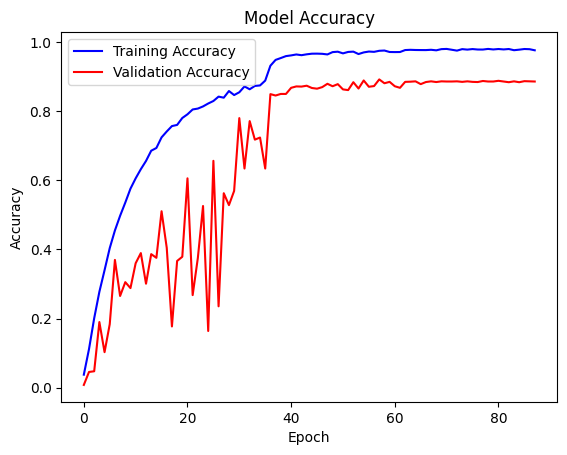

In [16]:
plt.plot(history.history['acc'], color='blue', label='Training Accuracy')
plt.plot(history.history['val_acc'],
         color='red', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot Training and Validation Loss

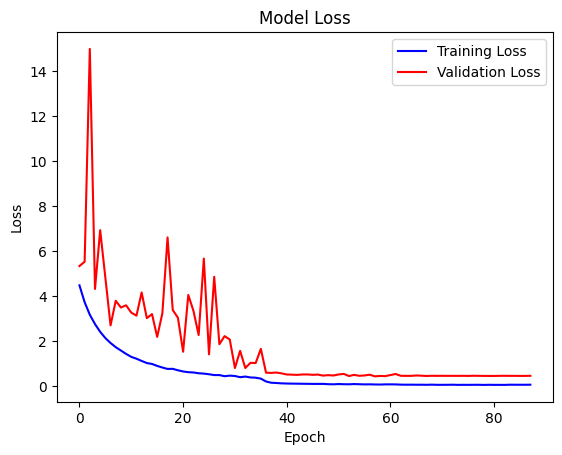

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'],
         color='red', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Plot Training and Testing Top 5 Accuracy

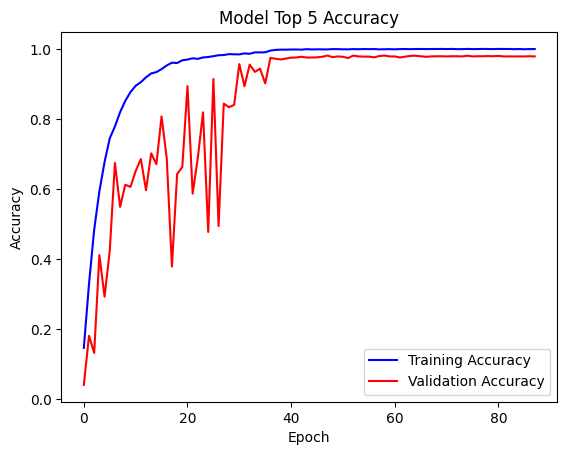

In [18]:
plt.plot(history.history['top_5_accuracy'],
         color='blue', label='Training Accuracy')
plt.plot(history.history['val_top_5_accuracy'],
         color='red', label='Validation Accuracy')
plt.title('Model Top 5 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()